# South African Language Identification Hack 2022

# EDSA 2201 & 2207 classification hackathon

©  Explore Data Science Academy


---

### Honour Code

I **Fielami Emmanuel David**, confirm - by submitting this document - that the solutions in this notebook are a result of my own work and that I abide by the [EDSA honour code](https://drive.google.com/file/d/1QDCjGZJ8-FmJE3bZdIQNwnJyQKPhHZBn/view?usp=sharing)


### Overview

South Africa is a multicultural society that is characterised by its rich linguistic diversity. Language is an indispensable tool that can be used to deepen democracy and also contribute to the social, cultural, intellectual, economic and political life of the South African society.

The country is multilingual with 11 official languages, each of which is guaranteed equal status. Most South Africans are multilingual and able to speak at least two or more of the official languages.

<img src="sal.jpg" alt="train/test split ordering tweet" width="600px;">

In this challenge, you will take text which is in any of South Africa's 11 Official languages and identify which language the text is in. This is an example of NLP's Language Identification, the task of determining the natural language that a piece of text is written in.


- 1. analyse the data
- 2. clean the existing data set;
- 3. determine if additional features can be added to enrich the data set;
- 4. build a model that is capable of predicting language the text is in;
- 5. evaluate the accuracy of the best machine learning model;
- 6. explain the inner working of the model to a non-technical audience.


<a id="cont"></a>

## Table of Contents

<a href=#one>1. Importing Packages</a>

<a href=#two>2. Loading Data</a>

<a href=#three>3. Exploratory Data Analysis (EDA)</a>

<a href=#four>4. Data Engineering</a>

<a href=#five>5. Modeling</a>

<a href=#six>6. Model Performance</a>

<a href=#seven>7. Model Explanations</a>

 <a id="one"></a>
## 1. Importing Packages
<a href=#cont>Back to Table of Contents</a>

In this section we will be importing the required libraries to manipulate and model the data

In [36]:
import re
import string
import numpy as np
import pandas as pd

from nltk.tokenize import word_tokenize, TreebankWordTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import preprocessing

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder

from sklearn.metrics import classification_report
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

from wordcloud import WordCloud, STOPWORDS , ImageColorGenerator

RANDOM_STATE = 42

import warnings
warnings.filterwarnings('ignore')

<a id="two"></a>
## 2. Loading the Data
<a href=#cont>Back to Table of Contents</a>

We will first start by loading in our data as pandas dataframe

In [2]:
#loading the training and testing data
train = pd.read_csv('train_set.csv')
test = pd.read_csv('test_set.csv')

In [3]:
#load the sample submission file
sample_submission = pd.read_csv('sample_submission.csv')

In [4]:
#let's take look at the frist few row of the training dataset
train.head()

,lang_id,text
0,xho,umgaqo-siseko wenza amalungiselelo kumaziko ax...
1,xho,i-dha iya kuba nobulumko bokubeka umsebenzi na...
2,eng,the province of kwazulu-natal department of tr...
3,nso,o netefatša gore o ba file dilo ka moka tše le...
4,ven,khomishini ya ndinganyiso ya mbeu yo ewa maana...


In [5]:
#let's a look at the test dataset
test.head()

,index,text
0,1,"Mmasepala, fa maemo a a kgethegileng a letlele..."
1,2,Uzakwaziswa ngokufaneleko nakungafuneka eminye...
2,3,Tshivhumbeo tshi fana na ngano dza vhathu.
3,4,Kube inja nelikati betingevakala kutsi titsini...
4,5,Winste op buitelandse valuta.


The test dataset contains `text` and `index` column 

Moving on next, let's take look at the `sample submission` file to see what we are suppose to submit after performing the modeling

In [6]:
sample_submission.head()

,index,lang_id
0,1,tsn
1,2,nbl


The sample submission file shows that we are going to submit a dataframe with two columns which are the `index` and `lang_id` column.


<a id="three"></a>
## 3. Exploratory Data Analysis (EDA)
<a class="anchor" id="1.1"></a>
<a href=#cont>Back to Table of Contents</a>

---
    
| ⚡ Description: Exploratory data analysis ⚡ |
| :--------------------------- |
| In this section, I will perform an in-depth analysis of all the variables in the DataFrame. |

---


**Exploratory Data Analysis** (EDA), First we will start by exploring our dataset to understand the data that we are working with and to gain more insights into the dataset

### Null values check

The presence of null value in our dataset, will negatively impact on the choice of model, hence it is necesary we confirm if null values exist in the data set to enable me decide on how to treat same before modeling.

In [7]:
#checking for null values in the training data
train.isnull().sum()

lang_id    0
text       0
dtype: int64

Looks good we don't have any null values in the training dataset

The **index** is the index of the text we predicted and the **lang_id** is the prediction we made on the text column of the test data

In [8]:
#let take look at the shap of the training dataframe
train.shape[0]
print("The training dataframe contains: {0} and {1} columns".format(train.shape[0], train.shape[1]))

The training dataframe contains: 33000 and 2 columns


Moving on next let's take closer on the target variable `lang_id`

In [9]:
#taking at number of unique values in lang_id
print("The target variable lang_id has {0} number unique values".format(train['lang_id'].nunique()))

The target variable lang_id has 11 number unique values


In [10]:
#let's take a look at the unique values
train['lang_id'].unique()

array(['xho', 'eng', 'nso', 'ven', 'tsn', 'nbl', 'zul', 'ssw', 'tso',
       'sot', 'afr'], dtype=object)

We will take a look at the sample distribution of target variable to gain more insight 

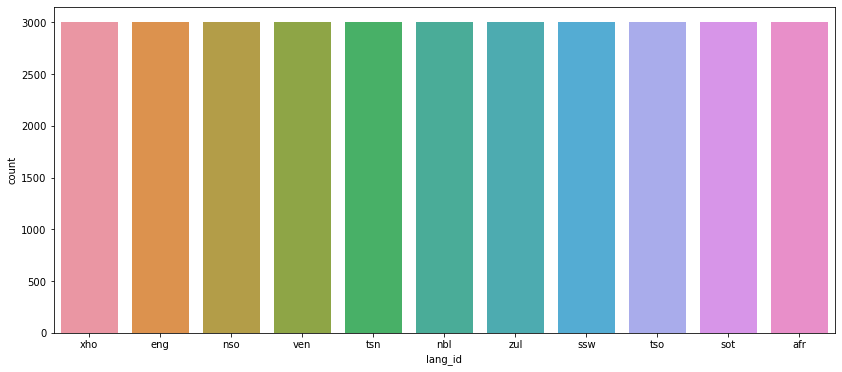

In [11]:
#using seaborn's countplot function
fig, axis = plt.subplots(figsize=(14, 6))
axis = sns.countplot(x='lang_id', data=train)
plt.show()

As we can see from the above plot the unique values inside the target variable are uniform, which means that our data is balance

In [12]:
#taking a look at the text column
train['text']

0        umgaqo-siseko wenza amalungiselelo kumaziko ax...
1        i-dha iya kuba nobulumko bokubeka umsebenzi na...
2        the province of kwazulu-natal department of tr...
3        o netefatša gore o ba file dilo ka moka tše le...
4        khomishini ya ndinganyiso ya mbeu yo ewa maana...
                               ...                        
32995    popo ya dipolateforomo tse ke go tlisa boetele...
32996    modise mosadi na o ntse o sa utlwe hore thaban...
32997    closing date for the submission of completed t...
32998    nawuphina umntu ofunyenwe enetyala phantsi kwa...
32999    mafapha a mang le ona a lokela ho etsa ditlale...
Name: text, Length: 33000, dtype: object

Looking at the output above the data does not look like needs additional cleaning, But if anything the `text` contains just punctuation marks

#### Word Cloud : Visualise the most common words for each unique language

To achieve this act, we make use of word cloud.

In [13]:
# Create a copy of our dataset for word cloud
train_cloud = train.copy()
train_cloud.head()

,lang_id,text
0,xho,umgaqo-siseko wenza amalungiselelo kumaziko ax...
1,xho,i-dha iya kuba nobulumko bokubeka umsebenzi na...
2,eng,the province of kwazulu-natal department of tr...
3,nso,o netefatša gore o ba file dilo ka moka tše le...
4,ven,khomishini ya ndinganyiso ya mbeu yo ewa maana...


#### World Cloud - process the text colunm before visualization 

Here, we quickly remove unwanted text and convert all text to small letters, to enable uniformity and aid proper visualization.

In [14]:
# Preproceessing functions
def preprocess_lang(df, col):
    """ Functions takes in a pandas dataframe and performs a series of steps on 
        the tweet/message/text column"""
    # Converting the whole text to lowercase
    df[col] = df[col]. apply(lambda x: x.lower())

    # Removing the twitter usernames from tweet string
    df[col] = df[col]. apply(lambda x: re.sub(r'@\w+', ' ', x))

    # Removing the URLS from the tweet string
    df[col] = df[col]. apply(lambda x: re.sub(r'@\w+', ' ', x))

    # Removing the URLS from the tweet string
    df[col] = df[col]. apply(lambda x: re.sub(r'http\S+', ' ', x))

    # Deleting everything that is not characters
    df[col] = df[col]. apply(lambda x: re.sub(r'[^a-z A-Z]', ' ', x))

    # Deleting any word which is less than 3-characters mostly those are stopwords
    df[col] = df[col]. apply(lambda x: re.sub(r'\b\w{1,2}\b', '', x))

    # Stripping extra spaces in the text
    df[col] = df[col]. apply(lambda x: re.sub(r' +', ' ', x))
    
    return df



In [15]:
# Process the text column to enable word cloud vizualisation
preprocess_lang(train_cloud, 'text')
train_cloud.head()

,lang_id,text
0,xho,umgaqo siseko wenza amalungiselelo kumaziko ax...
1,xho,dha iya kuba nobulumko bokubeka umsebenzi nap...
2,eng,the province kwazulu natal department transpor...
3,nso,netefat gore file dilo moka dumelelanego ona ...
4,ven,khomishini ndinganyiso mbeu ewa maana nga mula...


In [16]:
# Create a function that creates a list of dataframes with unique values
def create_df(data, col):
    """
        This function accept a dataframe, a column, which unique values serves as a condition for the numbers of 
        new dataframes it forms. It returns a list of dataframe
    """
    col_val = data[col].unique()

    # Create a list of dataframes
    df_list = [data[data[col]== val] for val in col_val]    
    
    return df_list
    

#### Word Cloud - create new dataframes for each unique languages

This act is needed for word cloud operation

In [17]:
# Create a list of dataframe with the unique languages in the lang_id column
languages_df = create_df(train_cloud, 'lang_id')

print(f' Created {len(languages_df)} new dataframes for the languages')

 Created 11 new dataframes for the languages


In [18]:
# Visualize the first five rows for the first dataframe in the dataframe list created above
languages_df[0].head()

,lang_id,text
0,xho,umgaqo siseko wenza amalungiselelo kumaziko ax...
1,xho,dha iya kuba nobulumko bokubeka umsebenzi nap...
28,xho,langa eli xesha nesizathu salo zingasinika ama...
43,xho,abafaki zicelo abadla umhlala phantsi ncedani ...
59,xho,intsilelo ligcisa ukthobela ukuziphatha okumis...


#### Word Cloud - create a list of documents

For this operation, we create a list of documents. Each documents contains all text for each unique language, in the language dataframe created above.

In [19]:
# Create a function that returns a list of documents from each language dataframe
def creat_doc(df_list, text_col):
    """
        This function accepts a list of dataframes, and a column with text values, which it references to create a document
        with all text in the column.
        It returns a list of documents.
    """
    doc_list = []
    
    for df in df_list :
        doc =   " ".join(text for text in df[text_col])
        doc_list.append(doc)
    
    return doc_list

In [20]:
# Create a list of documents for the text column in each dataframes stored in languages_df
documents_list = creat_doc(languages_df, 'text')

print(f' Created {len(documents_list)} list of documents from the dataframes of unique languages created above')

 Created 11 list of documents from the dataframes of unique languages created above


#### Word Cloud - Generate a list of word cloud objects

For the list of documents created above, we proceed to generate a word cloud object for each word document in the list.

In [21]:
# Create a function to generate a list of world cloud object from the document list created above
def generate_wordCloud(doc_list):
    """
        This function recieves a list of documents, generates and returns a list of word cloud object with 100 words
        for each document in the list.
    """
    word_cloud_list = []
    
    for doc in doc_list :
        wordcloud = WordCloud(background_color='black',max_font_size=50, max_words=100).generate(doc)
        word_cloud_list.append(wordcloud)
        
    return word_cloud_list

In [22]:
# Create a list of word cloud for each document in the document list created above
wordcloud_list = generate_wordCloud(documents_list)

print(f' Created {len(wordcloud_list)} list of world cloud for each document in the document list created above')

 Created 11 list of world cloud for each document in the document list created above


#### Word Cloud - Visualization 

We write a function to visualize each word cloud object in the word cloud list created above.

In [23]:
# Create a function to display the word in each worldcloud item for the world cloud list generated above.
def display_wordcloud(word_list):
    """
        This function recieves a list of word cloud, and a corresponding label list for the word cloud. 
        It prints each word cloud in the list
    """

    languages = train['lang_id'].value_counts().index.to_list()
    fig, ax = plt.subplots(len(word_list), 1, figsize  = (30,40))
    for index, word in enumerate(word_list):
        ax[index].imshow(word, interpolation='bilinear')
        ax[index].set_title(languages[index],fontsize=30)
        ax[index].axis('off')

    return None

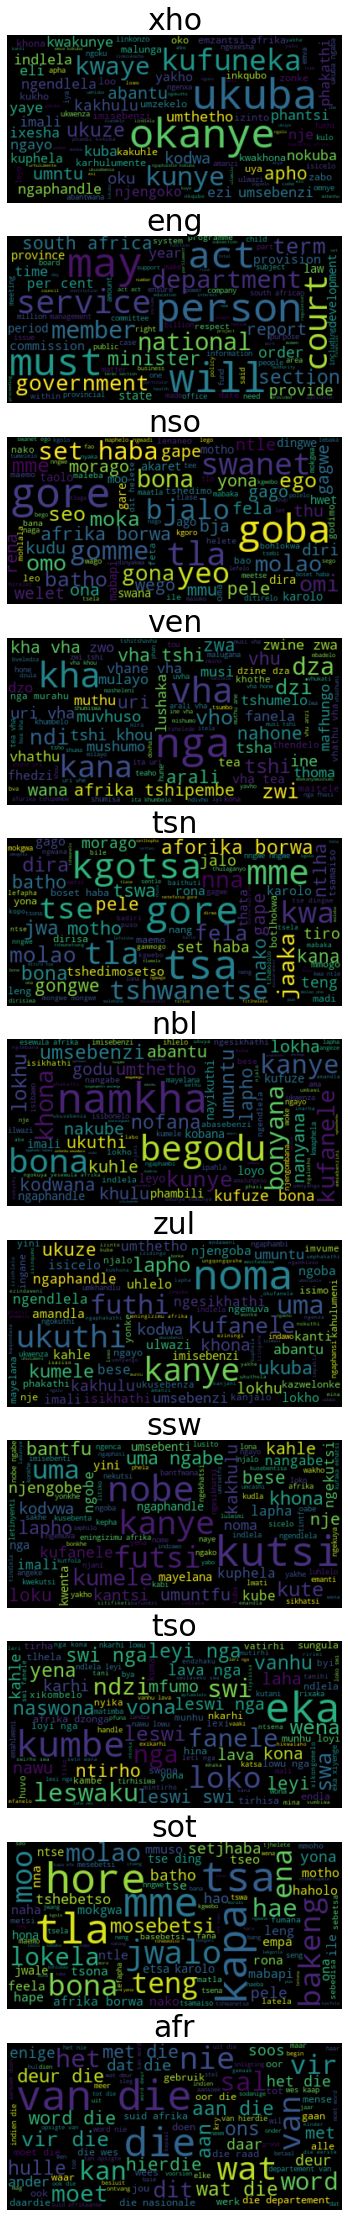

In [24]:
# Display the word cloud objects as images
display_wordcloud(wordcloud_list)

### EDA summary
- The dataset contains two columns (lang_id and text)
- both columns in the data set are in string format
- text columns contains writen words in different languages
- lang_id columns contains the language name for the corresponding text columns
- words with more than two characters appears most
- no similar words among the documents
- the lang_id colunm is an object type and we need to transform it to numeric type

<a id='four'></a>
# 4. Feature Engineering
<a href=#cont>Back to Table of Contents</a>

In this Section we will be applying feature engineering to the data set before trying to model the data we first have to convert the data from `letters` to `numbers`

In [25]:
#select the feature and the target variable
X = train['text']
y = train['lang_id']

We will instantiate labelEncoder we will be using the label encoder to encode the target variable from categorical to numerical values

In [26]:
#instantiation of labelEncoder
le = LabelEncoder()

In [27]:
#transform the target variable to numbers
y = le.fit_transform(y)

Next, using the ContVectorizer we will transform the feature

In [28]:
#using countVectoerizer
vectorizer = CountVectorizer()

In [29]:
#transforming the feature variable
X_count = vectorizer.fit_transform(X)

In [30]:
#shape of the feature after applying the countvectorizer
X_count.shape

(33000, 141958)

Next up we will split our dataset into training and test data using `train_test_split`

In [31]:
# Split Data (into Training & Test)
X_train, X_test, y_train, y_test = train_test_split(X_count, y, test_size=0.25, random_state=0)


## Test Data

We will be applying the same thing we did on the training dataset to the test dataset here, all the steps here are thesame as above

In [32]:
test.head()

,index,text
0,1,"Mmasepala, fa maemo a a kgethegileng a letlele..."
1,2,Uzakwaziswa ngokufaneleko nakungafuneka eminye...
2,3,Tshivhumbeo tshi fana na ngano dza vhathu.
3,4,Kube inja nelikati betingevakala kutsi titsini...
4,5,Winste op buitelandse valuta.


In [33]:
#applying countVectorizer on the test dataset
x_test = vectorizer.transform(test['text'])

In [34]:
x_test.shape

(5682, 141958)

<a id='five'></a>
# 5. Modeling
<a href=#cont>Back to Table of Contents</a>

In This Section we will be modeling our dataset using multiple models to see which model performs the best

In [37]:
#modeling 
clf = RandomForestClassifier(random_state = 42)
knn = KNeighborsClassifier()
naive_bayes = MultinomialNB()

In [39]:
#fitting the model
clf.fit(X_train, y_train)
knn.fit(X_train, y_train)
naive_bayes.fit(X_train, y_train)

MultinomialNB()

In [40]:
#apply prediction to the model
y_pred = clf.predict(X_test)
y_knn = knn.predict(X_test)
y_nv = naive_bayes.predict(X_test)

<a id='six'></a>
# 6. Mode performances
<a href=#cont>Back to Table of Contents</a>

Model Evaluation In this section we will evalute the above trained models to which model has the the best performance i.e the model with the highest `F1_score` and making sure that the model is not `over` or `under fitting` the data

In [41]:
#f1_score for the knn model
f1_knn = f1_score(y_test, y_knn, average = 'weighted')
print("The f1_score of the knn model is: {}".format(f1_knn))
#f1_score for RandomForestClassifier model
f1_clf = f1_score(y_test, y_pred, average = 'weighted')
print("The f1_score of the forest model is: {}".format(f1_clf))
#f1_score for the naive model
f1_naive = f1_score(y_test, y_nv, average = 'weighted')
print("The f1_score of the naive model is: {}".format(f1_naive))

The f1_score of the knn model is: 0.9233981659859274
The f1_score of the forest model is: 0.9865861157986
The f1_score of the naive model is: 0.9992730020680997


In [42]:
performance = pd.DataFrame([f1_knn, f1_clf, f1_naive], columns=['F1_Scores'])
performance.head()

,F1_Scores
0,0.923398
1,0.986586
2,0.999273


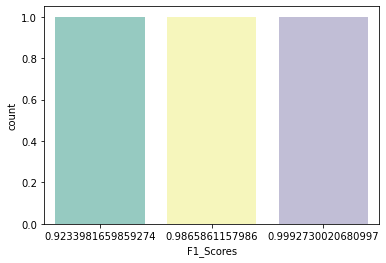

In [43]:
#using seaborn's countplot function
fig, axis = plt.subplots(figsize=(6, 4))
axis = sns.countplot(x='F1_Scores', data=performance, palette="Set3")
plt.show()

Will as you can see the model with the best performace here is `naive bayes` model it has the highest F1_score out of the other two models

### Applying the model to make prediction on an unseen data

In this Section we will apply the model on the test dataset

In [44]:
#making predictions
prediction = naive_bayes.predict(X_test)

In [45]:
#transforming the prediction from numbers to word
prediction = le.inverse_transform(prediction)
prediction

array(['sot', 'sot', 'sot', ..., 'afr', 'tsn', 'zul'], dtype=object)

### Creating a dataframe for the prediction 

In [46]:
submission = pd.DataFrame(list(zip(test['index'], prediction)), columns=['index', 'lang_id'])

In [47]:
submission.head()

,index,lang_id
0,1,sot
1,2,sot
2,3,sot
3,4,sot
4,5,tsn


Next we will save the file as csv

In [48]:
#saving the file as csv for submission
submission.to_csv('submission_v18.csv', index=False, index_label=False)